# Trustpilot API Customer Review Sentiment Analysis

## Summary
In this project, we fetch customer reviews from the Trustpilot API and perform sentiment analysis using OpenAI's GPT-4. The steps include fetching reviews, cleaning and preprocessing the data, analyzing sentiment, and visualizing the results. Finally, the processed data is stored in an Azure SQL Database for further analysis and reporting.


## Step 1: Import Libraries and Setup API Keys
In this step, we will import the necessary libraries and set up the API keys for Trustpilot and OpenAI.


In [11]:
import requests
import pandas as pd
import openai
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from time import sleep
import getpass

# Replace with your OpenAI API key
openai_api_key = getpass.getpass("Enter your OpenAI API key: ")
openai.api_key = openai_api_key


Enter your OpenAI API key: ········


## Step 2: Fetch Reviews from Trustpilot
We will fetch customer reviews from the Trustpilot website using web scraping techniques.

In [13]:
def soup2list(src, list_, attr=None):
    if attr:
        for val in src:
            list_.append(val[attr])
    else:
        for val in src:
            list_.append(val.get_text())

users = []
userReviewNum = []
ratings = []
locations = []
dates = []
reviews = []

from_page = 1
to_page = 6
company = 'mefx.company'

for i in range(from_page, to_page+1):
    result = requests.get(fr"https://www.trustpilot.com/review/{company}?page={i}")
    soup = BeautifulSoup(result.content, 'html.parser')
    
    # Trust Pilot was setup in a way that's not friendly to scraping, so this hacky method will do.
    soup2list(soup.find_all('span', {'class','typography_heading-xxs__QKBS8 typography_appearance-default__AAY17'}), users)
    soup2list(soup.find_all('div', {'class','typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua'}), locations)
    soup2list(soup.find_all('span', {'class','typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l'}), userReviewNum)
    soup2list(soup.find_all('div', {'class','styles_reviewHeader__iU9Px'}), dates)
    soup2list(soup.find_all('div', {'class','styles_reviewHeader__iU9Px'}), ratings, attr='data-service-review-rating')
    soup2list(soup.find_all('div', {'class','styles_reviewContent__0Q2Tg'}), reviews)

    # To avoid throttling
    sleep(1)

reviews_df = pd.DataFrame(
{
   'Username':users,
   'Total reviews':userReviewNum,
   'Location':locations,
   'Date':dates,
   'Content':reviews,
   'Rating': ratings
})

reviews_df


,Username,Total reviews,Location,Date,Content,Rating
0,Darryl Hayton,3 reviews,GB,"Nov 25, 2022",It's going to be an amazing festive…It's going...,5
1,Jude Crown,1 review,CA,"Oct 25, 2022",I have never believed in anything…I have never...,5
2,Stéphane MOTARD,4 reviews,ES,"Aug 6, 2022",Still with the same opinionStill with the same...,1
3,Mahadev Kumar,2 reviews,NP,"Oct 25, 2022",I have never been this lucky in…I have never b...,5
4,Βίκυ Χύτα,3 reviews,GR,"Oct 25, 2022",No regrets since I started investing…No regret...,5
...,...,...,...,...,...,...
111,Asling Elvis,1 review,US,"Jan 29, 2022",Amazing investment company with good…Amazing i...,5
112,Elfrem Neftalem,1 review,GB,"Jun 4, 2021",Amazing passive income projectDate of experien...,5
113,Nabinur Islam,1 review,BD,"Jun 2, 2021",Best Investment platformDate of experience: Ju...,5
114,Byron Clark,1 review,US,"Jun 1, 2021","Awesome platform!Date of experience: June 01, ...",5


## Step 3: Clean and Preprocess the Data
Next, we'll clean and preprocess the scraped data to make it suitable for sentiment analysis. This includes removing HTML tags, non-alphabetical characters, converting to lowercase, and removing extra spaces.

In [3]:
# Cleaning and Preprocessing the Data
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function to the review text
reviews_df['Cleaned_Content'] = reviews_df['Content'].apply(clean_text)

# Display cleaned data
display(reviews_df)


,Username,Total reviews,Location,Date,Content,Rating,Cleaned_Content
0,Darryl Hayton,3 reviews,GB,"Nov 25, 2022",It's going to be an amazing festive…It's going...,5,its going to be an amazing festiveits going to...
1,Jude Crown,1 review,CA,"Oct 25, 2022",I have never believed in anything…I have never...,5,i have never believed in anythingi have never ...
2,Stéphane MOTARD,4 reviews,ES,"Aug 6, 2022",Still with the same opinionStill with the same...,1,still with the same opinionstill with the same...
3,Mahadev Kumar,2 reviews,NP,"Oct 25, 2022",I have never been this lucky in…I have never b...,5,i have never been this lucky ini have never be...
4,Βίκυ Χύτα,3 reviews,GR,"Oct 25, 2022",No regrets since I started investing…No regret...,5,no regrets since i started investingno regrets...
...,...,...,...,...,...,...,...
111,Asling Elvis,1 review,US,"Jan 29, 2022",Amazing investment company with good…Amazing i...,5,amazing investment company with goodamazing in...
112,Elfrem Neftalem,1 review,GB,"Jun 4, 2021",Amazing passive income projectDate of experien...,5,amazing passive income projectdate of experien...
113,Nabinur Islam,1 review,BD,"Jun 2, 2021",Best Investment platformDate of experience: Ju...,5,best investment platformdate of experience june
114,Byron Clark,1 review,US,"Jun 1, 2021","Awesome platform!Date of experience: June 01, ...",5,awesome platformdate of experience june


## Step 4: Analyze Sentiment Using GPT-4
In this step, we will use OpenAI's GPT-4 to analyze the sentiment of the cleaned review text.

In [9]:
# Function to analyze sentiment using GPT-4
def analyze_sentiment(review_text):
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": f"Categorize the sentiment of the following review into one of these categories: 'Very Positive', 'Positive', 'Neutral', 'Negative', 'Very Negative': '{review_text}'"}
        ]
    )
    #return response['choices'][0]['message']['content'].strip()
    return response.choices[0].message.content.strip()

# Applying sentiment analysis to cleaned reviews
reviews_df['Sentiment'] = reviews_df['Cleaned_Content'].apply(analyze_sentiment)


## Step 5: Visualize Sentiment and Ratings
We will visualize the sentiment and rating distributions using Matplotlib and Seaborn.

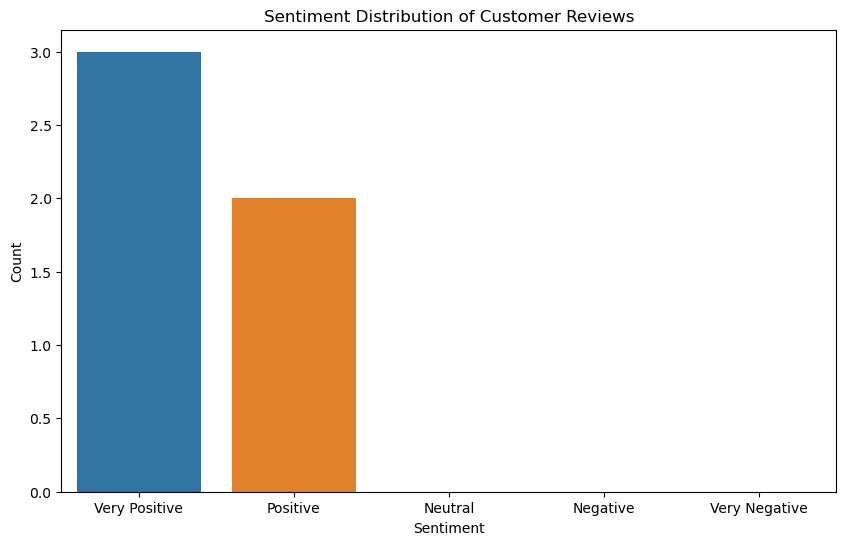

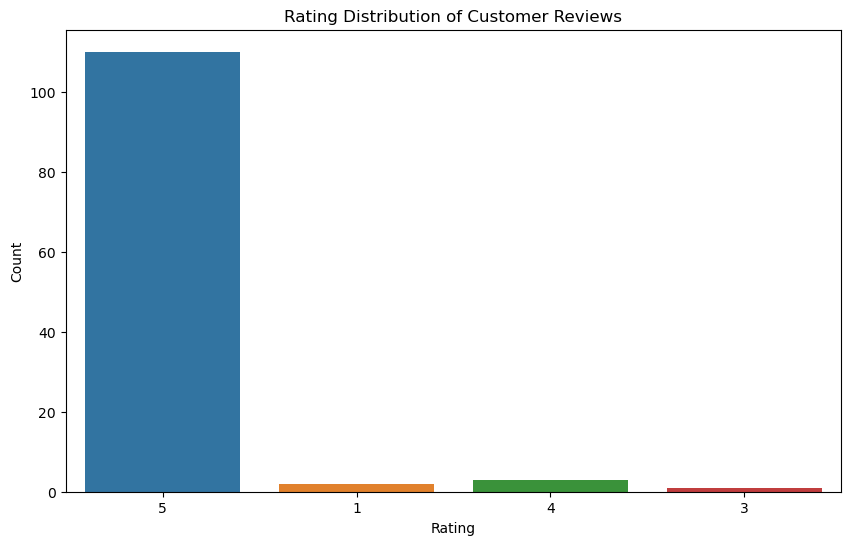

In [10]:
# Visualizing sentiment distribution
def visualize_sentiment(reviews_df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Sentiment', data=reviews_df, order=['Very Positive', 'Positive', 'Neutral', 'Negative', 'Very Negative'])
    plt.title('Sentiment Distribution of Customer Reviews')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

# Visualizing rating distribution
def visualize_ratings(reviews_df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Rating', data=reviews_df)
    plt.title('Rating Distribution of Customer Reviews')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()

# Visualizing the sentiment and rating distributions
visualize_sentiment(reviews_df)
visualize_ratings(reviews_df)
